# Continuous Distributions

This notebook is for Chapter 4 (Cumulative Distribution Functions) of [Think Stats - Probability and Statistics for Programmers](http://greenteapress.com/thinkstats/) by Allen B Downey.

Previous chapters have looked at __empirical distributions__ which are for finite samples. __Continuous distributions__ are characterized by a CDF that is a continuous function rather than a step function. Real-world phenomena can be modeled by continuous distributions.

Objective is to learn about some continuous distributions and how to to fit real data against them. If the data fits a model, the model can be used to make more predictions about the data.

In [75]:
from scipy.special import erf
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
%matplotlib inline

## Exponential Distribution

Text(0.5, 1.0, 'Exponential CDF')

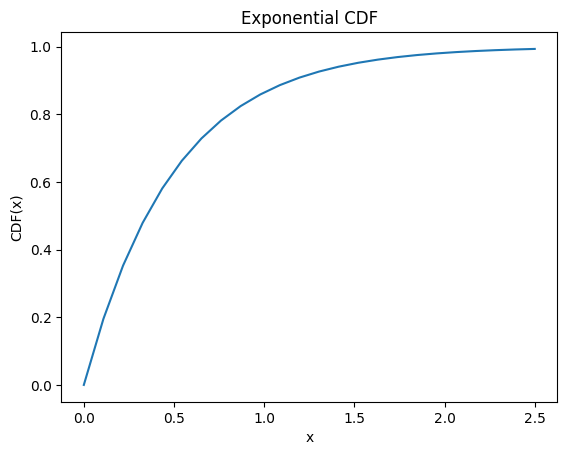

In [76]:
def cdf_exp(x, h):
    return 1.0 - np.exp(-h * x)

xs = np.linspace(0, 2.5, 24)
ys = [cdf_exp(x, 2) for x in xs]
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("CDF(x)")
plt.title("Exponential CDF")

### Plotting baby inter-arrival times

The babyboom.dat file provided here is extracted from the one provided in the book site by removing the metadata description.

In [77]:
babyboom = pd.read_fwf("babyboom.dat",
                      names=["time_of_birth", "sex", "birth_wgt", "num_minutes"],
                      colspecs=[(1, 8), (9, 16), (17, 24), (25, 32)])

# Convert 'num_minutes' column to numeric, handling errors by setting them as NaN
babyboom["num_minutes"] = pd.to_numeric(babyboom['num_minutes'], errors='coerce')

# Check for NaN values in the 'num_minutes' column
#print(babyboom[babyboom['num_minutes'].isna()])

# Optionally, drop rows with NaN values
babyboom = babyboom.dropna(subset=['num_minutes'])

# Now, convert the column to float
babyboom["num_minutes"] = babyboom["num_minutes"].astype(float)

# Computing itme between events
babyboom["ia_mins"] = -(babyboom["num_minutes"] - babyboom["num_minutes"].shift(-1))  


## Probability density function for Exponential distribution

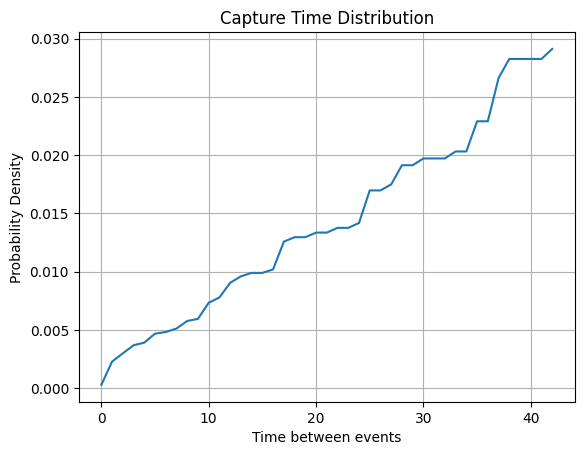

In [56]:
def pdf_exp(x, h):
    return h * np.exp(- h * x )
y = [pdf_exp(i , 0.03) for i in babyboom["ia_mins"]]

# Plot the column using Matplotlib
plt.plot(sorted(y))  # Replace 'column_name' with your actual column name
plt.xlabel('Time between events')
plt.ylabel('Probability Density')
plt.title('Capture Time Distribution')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Time between births')

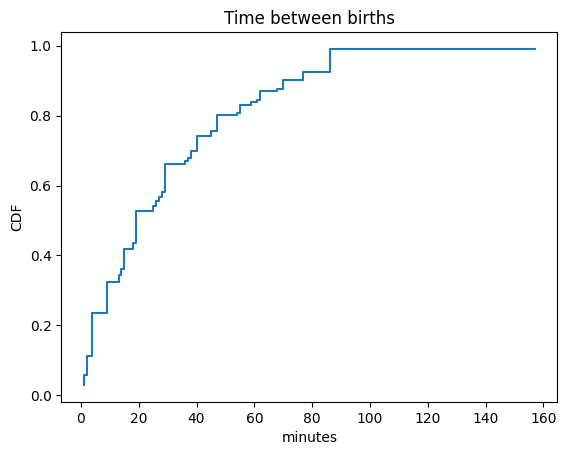

In [61]:
ia_mins = sorted(np.array(babyboom["ia_mins"]).tolist())[:-1]

# Compute lambda as 1/average (see http://www.milefoot.com/math/stat/pdfc-exponential.htm)
# print(len(ia_mins) / sum(ia_mins))
cdf_ia_mins = [cdf_exp(x, 0.03) for x in ia_mins]

plt.step(ia_mins, cdf_ia_mins)
plt.xlabel("minutes")
plt.ylabel("CDF")
plt.title("Time between births")

In order to prove that the distribution above is an exponential distribution, we need to plot the complementary CDF (CCDF = 1 - CDF) on a log scale. Since

$$CDF(x) = 1 - e^{-\lambda x}$$

$$CCDF(x) = e^{-\lambda x}$$

$$log(CCDF) = -\lambda x$$

So on a log-scale the CCDF should be a straight line with slope -h.

Text(0.5, 1.0, 'Time between births')

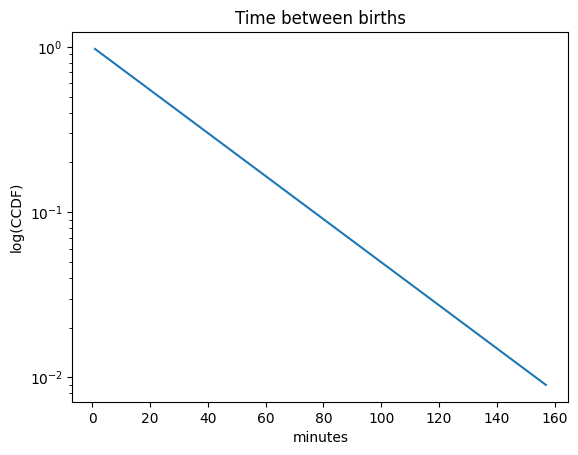

In [90]:
ccdf_ia_mins = [1.0 - x for x in cdf_ia_mins]

#plt.semilogy(range(len(ia_mins)), ccdf_ia_mins)
plt.semilogy(ia_mins, ccdf_ia_mins)
plt.xlabel("minutes")
plt.ylabel("log(CCDF)")
plt.title("Time between births")

For small values of n, we don't expect an empirical distribution to match a continuous distribution exactly. One way to evaluate the quality of fit is to generate a sample from a continuous distribution and see how well it matches the data.

We know the mean of our data is 32.6 mins. So lambda is 1/32.6 = 0.03. We use an exponential distribution CDF with this value of lambda to generate 44 values (same as our data) and compare the CCDF plot generated from the data to the one above.

Text(0.5, 1.0, 'Samples from Exponential Distribution')

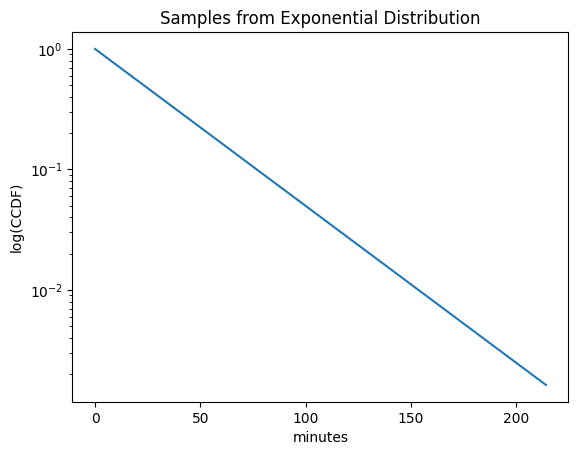

In [92]:
def cdf_exp_value(prob, h):
    """ Analytically reverse the exponential distribution function """
    return -math.log(1.0 - prob) / h

samples = []
for i in range(44):
    prob = np.random.random()
    samples.append(int(cdf_exp_value(prob, 0.03)))
samples_sorted = sorted(samples)

#data = np.random.exponential(0.03, 44)
#samples_sorted = sorted(data)

ccdf_samples = [1.0 - cdf_exp(x, 0.03) for x in samples_sorted]

#plt.semilogy(range(len(samples)), ccdf_samples)
plt.semilogy(samples_sorted, ccdf_samples)
plt.xlabel("minutes")
plt.ylabel("log(CCDF)")
plt.title("Samples from Exponential Distribution")

## Pareto Distribution

Originally used to describe the distribution of wealth, since then used to describe many natural and social phenomena. Equation is:

$$CDF(x) = 1 - (\frac{x}{m})^{\alpha}$$

where m = minimum possible value.

Text(0.5, 1.0, 'Pareto CDF')

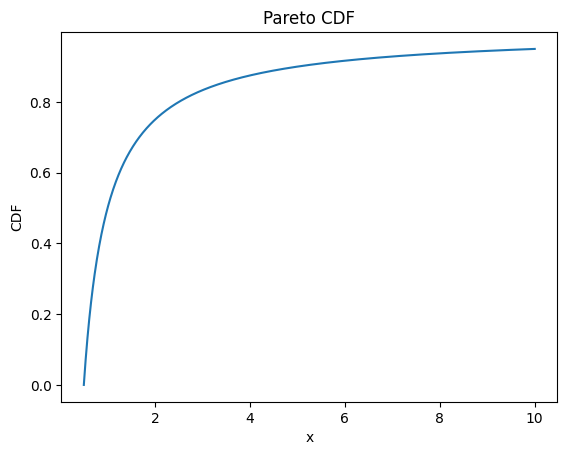

In [93]:
def cdf_pareto(x, m, a):
    if x < m:
        return 0.0
    return 1.0 - math.pow((1.0 * x / m), -a)

xs = np.linspace(0.5, 10, 1000).tolist()
ys = [cdf_pareto(x, 0.5, 1) for x in xs]

plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("CDF")
plt.title("Pareto CDF")

Simple visual test to see if an empirical distribution fits a Pareto distribution is to check that the log-log plot of the CCDF is a straight line.

$$CDF(x) = 1 - (\frac{x}{m})^{\alpha}$$

$$CCDF(x) = (\frac{x}{m})^{\alpha}$$

$$log(CCDF(x)) = -\alpha log(x) + \alpha log(m)$$

So slope of -a and intercept of a*log(m).

We take a sample from the distribution and plot it below.

Text(0.5, 1.0, 'Samples from Pareto Distribution')

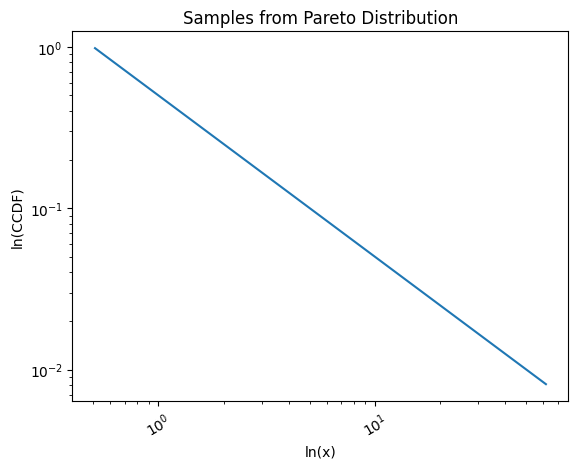

In [95]:
# # getting samples from built-in function
# samples = []
# for i in range(100):
#     samples.append(0.5 + random.paretovariate(1))
# sorted_samples = sorted(samples)

def cdf_pareto_value(prob, m, a):
    """ Analytically reverse the pareto function """
    return m * math.exp(-math.log(1.0 - prob, math.e) / a)

samples = []
for i in range(100):
    prob = np.random.random()
    samples.append(cdf_pareto_value(prob, 0.5, 1))
sorted_samples = sorted(samples)

ccdf_samples = [1.0 - cdf_pareto(x, 0.5, 1) for x in sorted_samples]

#plt.loglog(range(len(ccdf_samples)), ccdf_samples, basex=np.e, basey=np.e)

# Plot using log-log scale
#plt.loglog(range(len(ccdf_samples)), ccdf_samples)
plt.loglog(sorted_samples, ccdf_samples)

# Set base for x and y axis logarithm
#plt.xscale('log', basex=np.e)
#plt.yscale('log', basey=np.e)

plt.xlabel("ln(x)")
plt.ylabel("ln(CCDF)")
plt.xticks(rotation=30)
plt.title("Samples from Pareto Distribution")

### Pareto Human Heights Population

We generate 6B samples with m = 100cm and a = 1.7, we get a population of human heights with minimum 100cm and median 150cm.

In [96]:
# self-test to verify cdf_pareto_value is correct
median = cdf_pareto_value(0.5, 100, 1.7)
print("Median height value expected: 150 cm, actual: %.3f cm" % (median))

# generate samples (6B results in OOM)
samples = []
for i in range(60000):
    prob = np.random.random()
    samples.append(cdf_pareto_value(prob, 100, 1.7))

mean_height = 1.0 * sum(samples) / len(samples)
print("Mean height for sample: %.3f cm" % (mean_height))
num_shorter_than_mean = len([x for x in samples if x < mean_height])
print("Fraction shorter than mean: %.3f cm" % (num_shorter_than_mean / len(samples)))
print("Tallest person heigh: %.3f cm" % (max(samples)))

Median height value expected: 150 cm, actual: 150.341 cm
Mean height for sample: 240.691 cm
Fraction shorter than mean: 0.773 cm
Tallest person heigh: 64301.558 cm


### Pareto Word Count Distribution

Count words from "Alice in Wonderland" (not really a large corpus but illustrative) and check to see if the distribution results in a straight line log-log plot of CCDF to word count.

Text(0.5, 1.0, 'Word Counts CCDF plot')

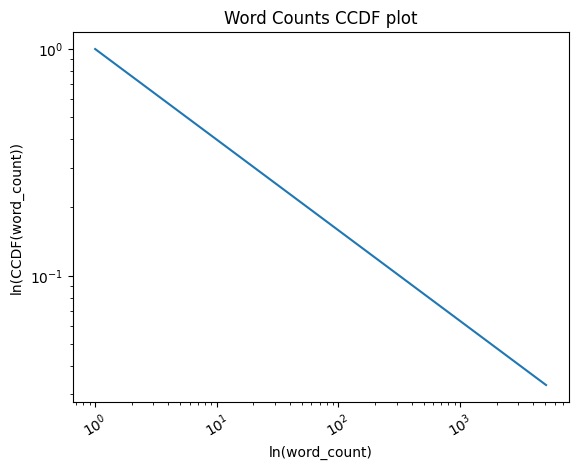

In [97]:
# Open the file in binary mode and specify the encoding
with open("alice_in_wonderland.txt", "rb") as f:
    # Read the file contents as bytes
    content = f.read()

# Decode the bytes to a string using the appropriate encoding
text = content.decode("utf-8")  # Replace "utf-8" with the actual encoding of your text

# Process the text
word_freqs = {}
for line in text.splitlines():
    if len(line) < 20:
        continue
    words = line.lower().split(" ")
    for word in words:
        word_freqs[word] = word_freqs.get(word, 0) + 1

word_counts = sorted(word_freqs.values())

# assume minimum word count is 1 and median is 5, analytically this works
# out to approximately 0.4 (1/ln(10))
ccdf_word_counts = [1.0 - cdf_pareto(x, 1, 0.4) for x in word_counts]

#plt.loglog(range(len(ccdf_word_counts)), ccdf_word_counts, basex=np.e, basey=np.e)
# Plot using log-log scale
plt.loglog(word_counts, ccdf_word_counts)
plt.xticks(rotation=30)
plt.xlabel("ln(word_count)")
plt.ylabel("ln(CCDF(word_count))")
plt.title("Word Counts CCDF plot")

### Weibull distribution

    CDF(x) = 1 - exp(-x / lambda)**k

Specialization of exponential distribution.

    CDF(x) = 1 - exp(-lambda * x)

Since we get a straight line from exponential by a semi-log plot, we should get the same if the x axis for the Weibull distribution is x\*\*k. Converting this to a log scale, we get k\*log(x). So we should get a straight line for a log-log plot. Testing this hypothesis by sampling from the distribution.

Text(0.5, 1.0, 'Samples from Weibull Distribution')

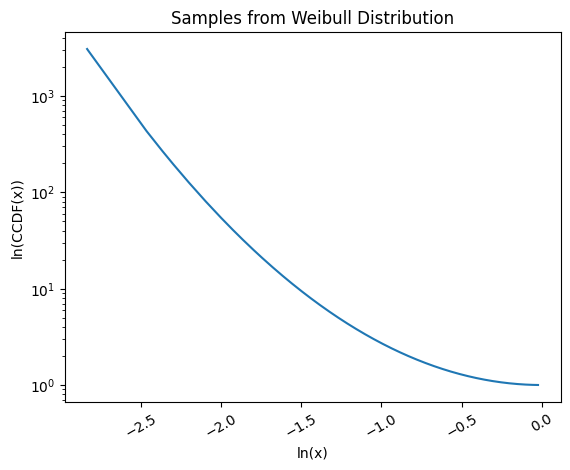

In [98]:
def cdf_weibull(x, h, k):
    if x == 0:
        return 0
    return 1.0 - math.exp(math.pow((-1.0 * x / h), k))

samples = []
for i in range(1000):
    samples.append(random.weibullvariate(-1, 2))
sorted_samples = sorted(samples)
ccdf_samples = [1.0 - cdf_weibull(x, -1, 2) for x in sorted_samples]

#plt.loglog(range(len(ccdf_samples)), ccdf_samples, basex=np.e, basey=np.e)
#plt.loglog(range(len(ccdf_samples)), ccdf_samples)
plt.semilogy(sorted_samples, ccdf_samples)
plt.xticks(rotation=30)
plt.xlabel("ln(x)")
plt.ylabel("ln(CCDF(x))")
plt.title("Samples from Weibull Distribution")

## Normal Distribution

Most commonly used because it describes many phenomena. 

$$PDF(x) = \frac{1}{\sigma \sqrt[]{2\pi}}e^{-\frac{(x-\mu^{2})}{2\sigma ^{2}}}$$

$$CDF(x) = \frac{1}{2} \left [ 1 + erf(\frac{x - \mu}{\sigma \sqrt{2}}) \right]$$

$$erf(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} e^{-t^{2}} dt$$

### Birth Weights

We fit the empirical CDF for the birth weights from the NSFG data and compare with an analytical CDF for the mean and variance.

Below 50 oz (20th percentile), data and model diverge, so if our study is concerned with very light (pre-term?) babies, then a normal distribution __would not be appropriate__.

In [99]:
pregnancies = pd.read_fwf("2002FemPreg.dat", 
                         names=["caseid", "nbrnaliv", "babysex", "birthwgt_lb",
                               "birthwgt_oz", "prglength", "outcome", "birthord",
                               "agepreg", "finalwgt"],
                         colspecs=[(0, 12), (21, 22), (55, 56), (57, 58), (58, 60),
                                (274, 276), (276, 277), (278, 279), (283, 285), (422, 439)])
pregnancies.head()

,caseid,nbrnaliv,babysex,birthwgt_lb,birthwgt_oz,prglength,outcome,birthord,agepreg,finalwgt
0,1,1.0,1.0,8.0,13.0,39,1,1.0,33.0,6448.271112
1,1,1.0,2.0,7.0,14.0,39,1,2.0,39.0,6448.271112
2,2,3.0,1.0,9.0,2.0,39,1,1.0,14.0,12999.542264
3,2,1.0,2.0,7.0,0.0,39,1,2.0,17.0,12999.542264
4,2,1.0,2.0,6.0,3.0,39,1,3.0,18.0,12999.542264


C:\Users\diptiwar\AppData\Local\Temp\ipykernel_4616\2435703702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  live_births["totwgt"] = live_births["birthwgt_lb"] * 16 + live_births["birthwgt_oz"]


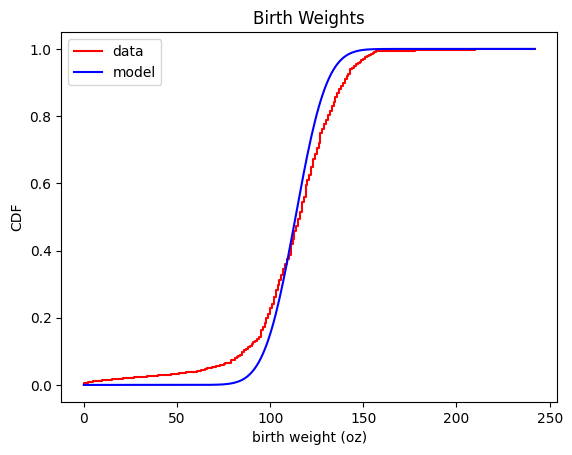

In [110]:
def cdf_normal(x, m, s):
    return 0.5 * (1.0 + erf((x - m) / s * math.sqrt(2.0)))

# plot CDF from data
live_births = pregnancies[pregnancies["outcome"] == 1]
live_births["totwgt"] = live_births["birthwgt_lb"] * 16 + live_births["birthwgt_oz"]
birth_wgts = np.array(live_births["totwgt"].dropna())

range_lb = np.min(birth_wgts)
range_ub = np.max(birth_wgts)
nbr_bins = range_ub - range_lb
pmf_birthwgts = np.histogram(birth_wgts, bins=int(nbr_bins), range=(range_lb, range_ub), 
                             density=True)
ps = np.cumsum(pmf_birthwgts[0])
xs = pmf_birthwgts[1][:-1]
plt.step(xs, ps, color='r', label="data")

# compute mean and standard deviation for data
mean = np.mean(birth_wgts)
std = np.std(birth_wgts)

# compute the CDF from the formula for each data point and plot
cdf_model = [cdf_normal(x, mean, std) for x in sorted(xs.tolist())]
plt.plot(range(len(cdf_model)), cdf_model, color="b", label="model")

plt.title("Birth Weights")
plt.xlabel("birth weight (oz)")
plt.ylabel("CDF")
plt.legend(loc="best")

### Wechsler Adult Intelligence Scale

Model this as a normal distribution with mean 100 and standard deviation 15. We investigate what fraction of the population has IQ greater than mean, above 115, 130 and 145.

A "six-sigma" IQ is 190 (100 + 6\*15). In a world of 6 billion people, how many do we expect to have an IQ of 190 or more?

In [102]:
prob_mean = 1.0 - cdf_normal(100, 100, 15)
prob_115 = 1.0 - cdf_normal(115, 100, 15)
prob_130 = 1.0 - cdf_normal(130, 100, 15)
prob_145 = 1.0 - cdf_normal(145, 100, 15)
prob_190 = 1.0 - cdf_normal(190, 100, 15)
print("Fraction of population with IQ > mean (100): %.5f" % (prob_mean))
print("Fraction of population with IQ > 115: %.5f" % (prob_115))
print("Fraction of population with IQ > 130: %.5f" % (prob_130))
print("Fraction of population with IQ > 145: %.11f" % (prob_145))
print("#-people (of 6B) with IQ > 190: %d" % (int(6000000000 * prob_190)))

Fraction of population with IQ > mean (100): 0.50000
Fraction of population with IQ > 115: 0.02275
Fraction of population with IQ > 130: 0.00003
Fraction of population with IQ > 145: 0.00000000099
#-people (of 6B) with IQ > 190: 0


### Live Births Distribution

The normal distribution does not seem to be a good model for this distribution, since the probability of births around weeks 39 and 40 are disproportionately higher than that predicted by a normal distribution with the same mean and standard deviation as the data.

38.56055968517709 2.702196104688822


Text(0, 0.5, 'Frequency')

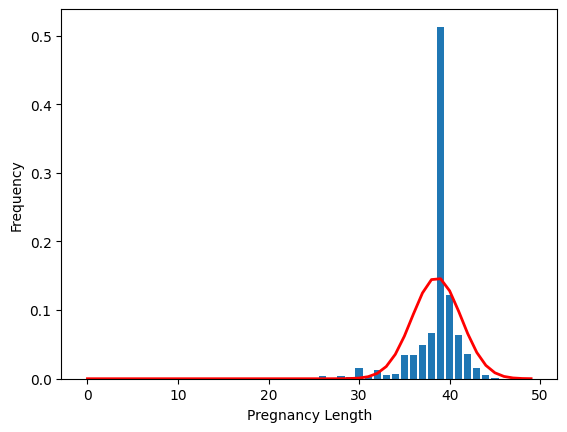

In [103]:
# plot the empirical distribution
preglens = np.array(live_births["prglength"].dropna())
pmf_preglens = np.histogram(preglens, bins=50, density=True)
plt.bar(pmf_preglens[1][:-1], pmf_preglens[0])

# plot the model distribution
mean = np.mean(preglens)
sd = np.std(preglens)
print(mean, sd)
pmf_model = (np.exp((-(pmf_preglens[1][:-1] - mean) ** 2) / (2 * sd ** 2)) / 
    (sd * np.sqrt(2 * np.pi)))
plt.plot(pmf_preglens[1][:-1], pmf_model, linewidth=2, color='r')

plt.xlabel("Pregnancy Length")
plt.ylabel("Frequency")

## Normal Probability Plots (Rankits)

Unlike Exponential, Pareto and Weibull distributions, there is no simple transformation to check if the normal distribution is a good model for some data. Alternative for normal distribution is probability plots. If you generate n values from a normal distribution and sort them, the k-th rankit is the mean of the distribution for the k-th value.

Cell below samples 6 numbers from a normal distribution N times, then calculates the mean. The mean values should converge to known rankit values.

In [33]:
samples = np.zeros((1, 6))
n = 10000
for i in range(n):
    samples = samples + np.sort(np.random.normal(0, 1, 6))
samples = samples / n
print(samples)

[[-1.26506272 -0.63926623 -0.19567941  0.20819631  0.64491916  1.26250534]]


Normal probability plots are a quick and dirty way of making sure that a dataset confirms to a particular distribution. It works for any distribution as long as you know how to generate a normal sample.

In this case, the curvature suggests deviations from normal, but normal distribution is usable for this dataset for our purposes.

Text(0.5, 1.0, 'Normal Probability Plot of Birth Weights')

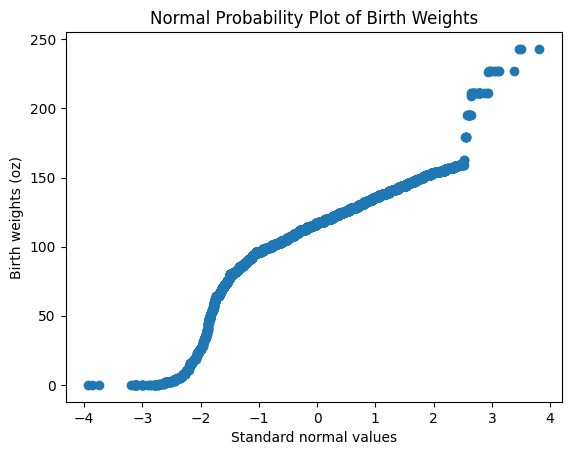

In [113]:
sample_size = birth_wgts.shape[0]
samples = np.sort(np.random.normal(0, 1, sample_size))
dataset = np.sort(birth_wgts)
plt.scatter(samples, dataset)
plt.xlabel("Standard normal values")
plt.ylabel("Birth weights (oz)")
plt.title("Normal Probability Plot of Birth Weights")

In [ ]:
pmf_birthwgts

## Lognormal Distribution

If log of values have a normal distribution, the values have a lognormal distribution. The CDF of the lognormal distribution is the same as the CDF of log(x) of a normal distribution.

$$CDF_{lognormal}(x) = CDF_{normal}(log(x))$$

### Adult Body Weights

Distribution of adult body weights are lognormal.

In [104]:
brfs_data = pd.read_fwf("CDBRFS08.ASC", 
                       names=["age", "weight2", "wtyrago", "sex", "htm3", "wtkg2"],
                       colspecs=[(100, 102), (119, 122), (127, 130), (142, 143), (1251, 1253),
                                 (1254, 1258)])
brfs_data.head()

,age,weight2,wtyrago,sex,htm3,wtkg2
0,82,156.0,168.0,2,57,7091
1,65,160.0,160.0,2,63,7273
2,48,777.0,NaN,2,65,9999
3,61,162.0,162.0,1,70,7364
4,26,195.0,195.0,1,85,8864


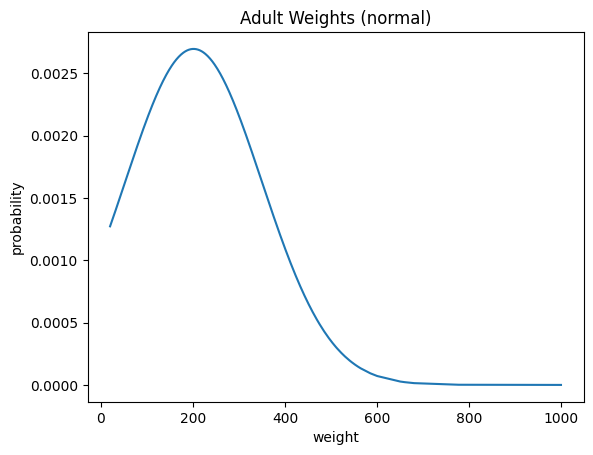

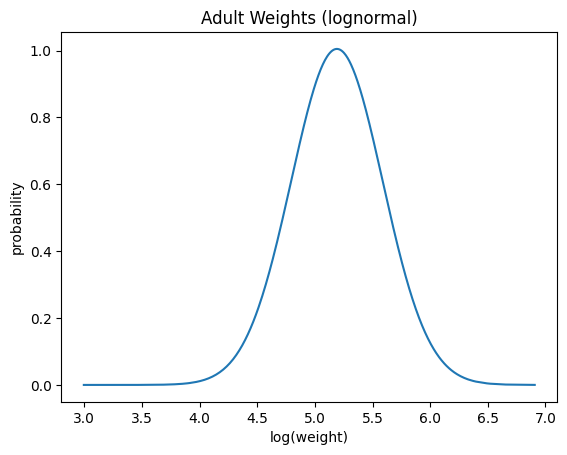

In [106]:
def pdf_normal(xs, m, s):
    return np.exp(-(xs - m)**2 / (2 * s**2)) / (s * np.sqrt(2 * np.pi))

# distribution of weights
weights = np.sort(np.array(brfs_data["weight2"].dropna()))
mean = np.mean(weights)
std = np.std(weights)
pdf_weights = pdf_normal(weights, mean, std)
plt.plot(weights, pdf_weights)
plt.title("Adult Weights (normal)")
plt.xlabel("weight")
plt.ylabel("probability")
plt.show()

# distribution of log weights
log_weights = np.sort(np.log(weights))
log_mean = np.mean(log_weights)
log_std = np.std(log_weights)
pdf_logweights = pdf_normal(log_weights, log_mean, log_std)
plt.plot(log_weights, pdf_logweights)
plt.title("Adult Weights (lognormal)")
plt.xlabel("log(weight)")
plt.ylabel("probability")
plt.show()

### Population of cities and towns

Solution from populations_cdf.py.

* On log-log scale tail of CCDF looks like Pareto but thats misleading.
* On log-x scale distribution looks like a lognormal distribution.
* Normal probability plot of log(x) confirms that the distribution is lognormal.

__NOTE__: many phenomena that can be described by Pareto models can often be described better by lognormal models.

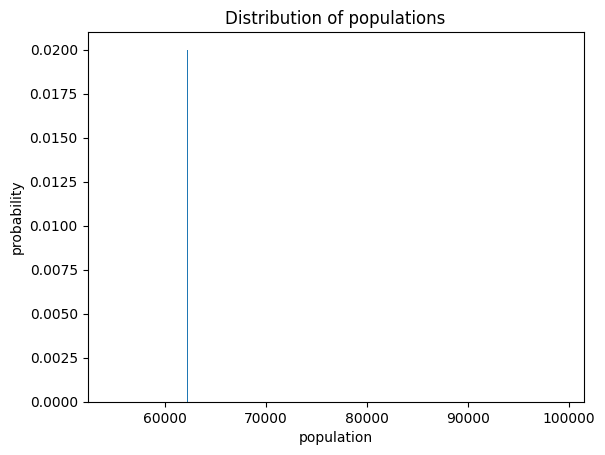

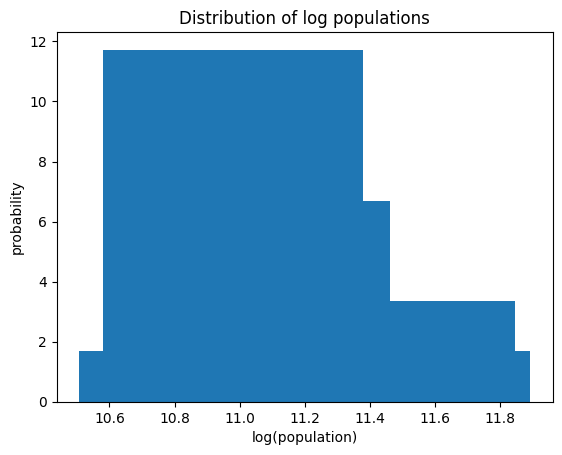

In [107]:
# pops = []
# #fpop = open("population.csv", 'rb')

# # Open the file in text mode and read the data as strings
# with open("population.csv", "r") as f:
#     text_data = f.read()

# # Encode the string data into bytes using UTF-8 encoding
# fpop = text_data.encode("utf-8")

# for line in fpop:
#     print(line)
#     line = line.strip()
#     if len(line) == 0:
#         continue
#     cols = line.split(",")
#     try:
#         pop = int(cols[-1])
#     except ValueError:
#         continue
#     pops.append(pop)
# fpop.close()

pops = pd.read_csv('population.csv')

populations = np.array(pops['Value'])[:50]

#populations = np.array(pops)
range_lb = np.min(populations)
range_ub = np.max(populations)
nbr_bins = range_ub - range_lb
pdf_populations = np.histogram(populations, bins=nbr_bins, range=(range_lb, range_ub), 
                               density=True)

plt.bar(pdf_populations[1][:-1], pdf_populations[0])
plt.title("Distribution of populations")
plt.xlabel("population")
plt.ylabel("probability")
plt.show()

log_populations = np.log(populations)
pdf_log_populations = np.histogram(log_populations, bins=50, density=True)
plt.bar(pdf_log_populations[1][:-1], pdf_log_populations[0])
plt.title("Distribution of log populations")
plt.xlabel("log(population)")
plt.ylabel("probability")
plt.show()

In [41]:
populations

array([54608, 55811, 56682, 57475, 58178, 58782, 59291, 59522, 59471,
       59330, 59106, 58816, 58855, 59365, 60028, 60715, 61193, 61465,
       61738, 62006, 62267, 62614, 63116, 63683, 64174, 64478, 64553,
       64450, 64332, 64596, 65712, 67864, 70192, 72360, 74710, 77050,
       79417, 81858, 84355, 86867, 89101, 90691, 91781, 92701, 93540,
       94483, 95606, 96787, 97996, 99212], dtype=int64)

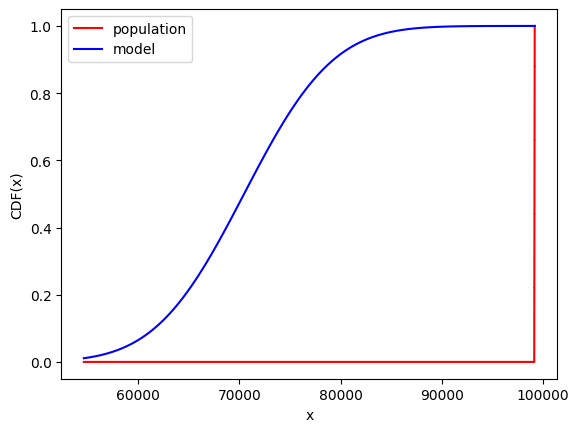

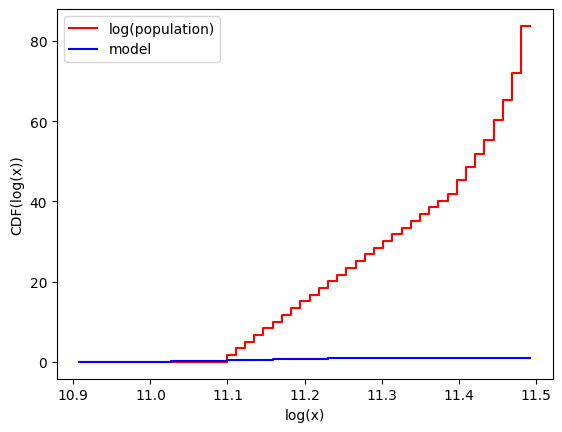

In [42]:
# normal
ps = np.cumsum(np.sort(pdf_populations[0]))
xs = pdf_populations[1][:-1]
plt.step(xs, ps, color="red", label="population")

mean = np.mean(populations)
std = np.std(populations)
ps_model = [cdf_normal(x, mean, std) for x in xs]
plt.step(xs, ps_model, color="blue", label="model")

plt.xlabel("x")
plt.ylabel("CDF(x)")
plt.legend(loc="best")
plt.show()

# lognormal
log_ps = np.cumsum(np.sort(pdf_log_populations[0]))
log_xs = pdf_log_populations[1][:-1]
plt.step(log_xs, log_ps, color="red", label="log(population)")

mean = np.mean(log_populations)
std = np.std(log_populations)
pl_model = [cdf_normal(x, mean, std) for x in log_xs]
plt.step(log_xs, pl_model, color="blue", label="model")

plt.xlabel("log(x)")
plt.ylabel("CDF(log(x))")
plt.legend(loc="best")

C:\Users\diptiwar\AppData\Local\Temp\ipykernel_4616\1232978453.py:3: RuntimeWarning: invalid value encountered in log
  samples = np.sort(np.log(np.random.normal(0, 1, sample_size)))


Text(0.5, 1.0, 'Normal Probability Plot of Populations')

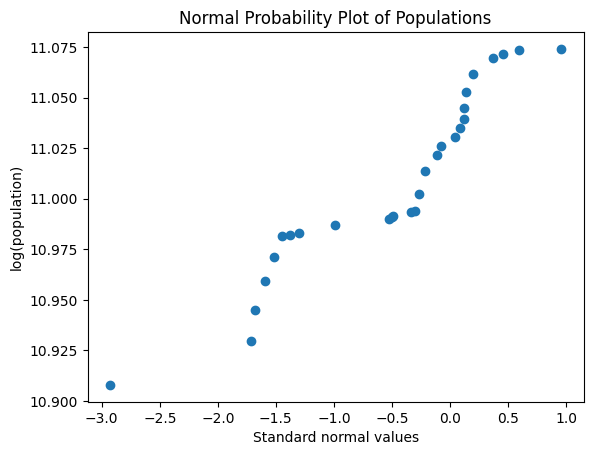

In [108]:
# lognormal looks like a good fit using normal probability plots
sample_size = populations.shape[0]
samples = np.sort(np.log(np.random.normal(0, 1, sample_size)))
dataset = np.sort(np.log(populations))
plt.scatter(samples, dataset)
plt.xlabel("Standard normal values")
plt.ylabel("log(population)")
plt.title("Normal Probability Plot of Populations")

### IRS Income Distribution

The best fit is with a normal log-log plot on the right of the chart, suggesting that a Pareto distribution might be a good fit.

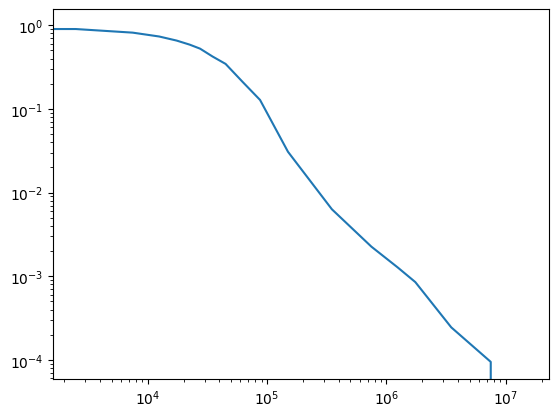

In [109]:
income_dist = [(0, 2489989), (2500, 11638707), (7500, 12139638), 
               (12500, 11702056), (17500, 11076002), (22500, 9866247), 
               (27500, 8743581), (35000, 14554280), (45000, 11087123), 
               (62500, 19196461), (87500, 11729485), (150000, 13851341),
               (350000, 3476747), (750000, 577618), (1250000, 140635), 
               (1750000, 59460), (3500000, 86329), (7500000, 21390), 
               (15000000, 13480)]
xs = np.array([x[0] for x in income_dist])
ys = np.array([x[1] for x in income_dist])
# plt.plot(xs, ys)

pmf_ys = ys * 1.0 / np.sum(ys)
# plt.plot(xs, pmf_ys)

ccdf_ys = 1.0 - np.cumsum(pmf_ys)
# plt.plot(xs, ccdf_ys)
# plt.semilogy(xs, ccdf_ys)
plt.loglog(xs, ccdf_ys)

# How to check if the data follows specific distribution

In [45]:
import numpy as np

# Generate example data
np.random.seed(0)
data = np.random.normal(loc=0, scale=1, size=1000)

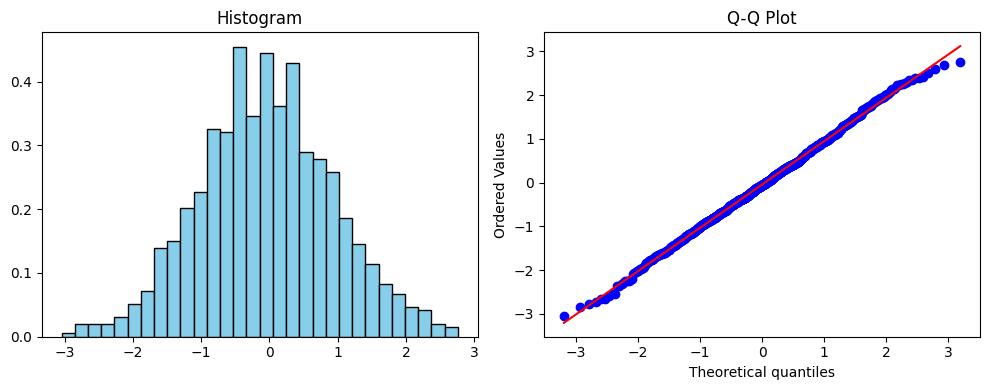

In [48]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Plot histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, density=True, color='skyblue', edgecolor='black')
plt.title('Histogram')

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.tight_layout()
plt.show()

In [49]:
# Shapiro-Wilk Test
statistic, p_value = stats.shapiro(data)
print(f"Shapiro-Wilk Test - p-value: {p_value}")

Shapiro-Wilk Test - p-value: 0.5912267898687746


In [50]:
# Mean and standard deviation estimation
mean_est = np.mean(data)
std_dev_est = np.std(data)
print(f"Estimated mean: {mean_est}, Estimated standard deviation: {std_dev_est}")

Estimated mean: -0.045256707490195384, Estimated standard deviation: 0.9870331586690257


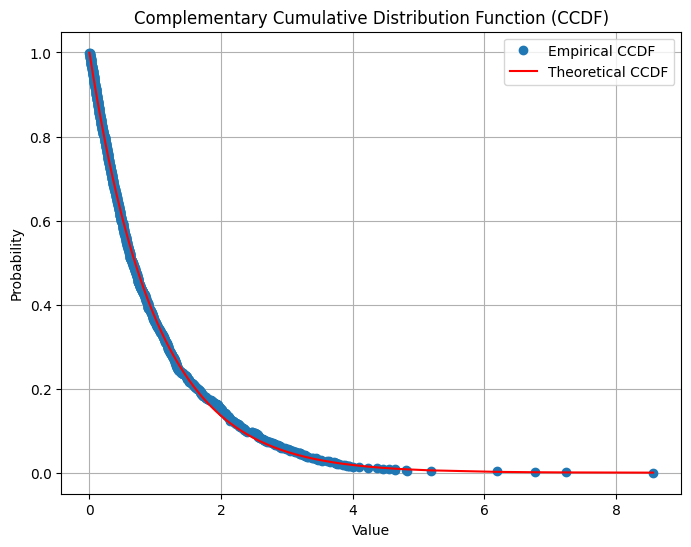

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generate example data from an exponential distribution
np.random.seed(0)
data = np.random.exponential(scale=1, size=1000)

# Sort the data in ascending order
sorted_data = np.sort(data)

# Calculate the empirical CCDF
ccdf_empirical = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Calculate the theoretical CCDF for the exponential distribution
lambda_param = 1  # Rate parameter for the exponential distribution
ccdf_theoretical = np.exp(-lambda_param * sorted_data)

# Plot the empirical and theoretical CCDFs
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, ccdf_empirical, label='Empirical CCDF', marker='o', linestyle='None')
plt.plot(sorted_data, ccdf_theoretical, label='Theoretical CCDF', color='red')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.legend()
plt.grid(True)
plt.show()